# S2 Scaling
Validating the scaling process with 10 runs of the Dual-input model. You must comment/uncomment transfromation and inverse-transfromation lines to generate results for the four scenarios discussed in the paper.

In [1]:
## Packages

import os
import csv
import math
import time as timeit
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from ta import add_all_ta_features
from ta.momentum import rsi, awesome_oscillator
from ta.trend import macd, cci, ema_indicator, sma_indicator
from ta.volatility import bollinger_hband, bollinger_lband, average_true_range
from ta.volume import on_balance_volume, money_flow_index

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.utils import plot_model

In [2]:
## Pre-processing

os.chdir('C:/Users/abolf/Jupyter/Forex')
dff = pd.read_csv('DATAF.csv')
dft = pd.read_csv('DATAT.csv')
dft = dft.drop(['Open'], axis= 1)

dft['ema'] = ema_indicator(dft['Close'], window=26)                             # trend
dft['macd'] = 10*macd(dft['Close'], window_slow=26, window_fast=12)             # trend
dft['rsi'] = sma_indicator(rsi(dft['Close'], window=12)/100, 6)                 # momentum, smoothed
dft['bbh'] = bollinger_hband(dft['Close'], window=26, window_dev=2)             # volatility
dft['bbl'] = bollinger_lband(dft['Close'], window=26, window_dev=2)             # volatility
dft['atr'] = 50*average_true_range(dft['High'],dft['Low'],dft['Close'], window=12) # volatility
dft['atr'] = sma_indicator(dft['atr'], 6)                                       # smoothing 

df = pd.concat([dff, dft], axis=1)
df = df.dropna()
y = df['Close']
df = df.drop(['Date','Close','High','Low'], axis= 1)
print('Shape of df & y:', df.shape, y.shape)
df.tail(4)

Shape of df & y: (6550, 12) (6550,)


,EURINF,USAINF,EURLTINT,USALTINT,EURUNEMP,USAUNEMP,ema,macd,rsi,bbh,bbl,atr
6571,2.2,2.4,3.24,4.285,6.2,4.2,1.056807,0.112805,0.729561,1.085152,1.017118,0.470690
6572,2.2,2.4,3.24,4.315,6.2,4.2,1.059162,0.120812,0.743572,1.089561,1.016623,0.475771
6573,2.2,2.4,3.24,4.273,6.2,4.2,1.061091,0.122997,0.737870,1.092916,1.016730,0.472166
6574,2.2,2.4,3.24,4.317,6.2,4.2,1.063077,0.125461,0.735717,1.096256,1.017221,0.468443


In [3]:
## 70% train, 15% valid, 15% test

split_train = round(0.70*len(df.index))   # train: 0:4585
split_valid = round(0.85*len(df.index))   # valid: 4586:5568
print('train size:', split_train, ', train+valid size:', split_valid)

# RobustScaler
rs = RobustScaler().fit(df.head(split_train))
df_rs = rs.transform(df)
y = y.to_numpy().reshape(-1, 1)
rsy = RobustScaler().fit(y[0:split_train])
y_rs = rsy.transform(y)
# uncomment and run IF not using
#df_rs = df
#y_rs = y

# MinMaxScaler
mm = MinMaxScaler().fit(df_rs)
df_std = mm.transform(df_rs)
df_std = pd.DataFrame(df_std, columns=df.columns)
mmy = MinMaxScaler().fit(y_rs)
y_std = mmy.transform(y_rs)
y_std = pd.DataFrame(y_std)
# uncomment and run IF not using
#df_std = pd.DataFrame(df_rs, columns=df.columns)
#y_std = pd.DataFrame(y_rs)
#df_std = df_std.iloc[0:split_valid,:]
#y_std = y_std.iloc[0:split_valid]

# sparse data to windowed slices
window_size = 10
def create_dataset(X, window_size):
    Xs = []
    for i in range(len(X) - window_size):
        v = X.iloc[i:(i + window_size)].values
        Xs.append(v)
    return np.array(Xs)

X = create_dataset(df_std, window_size)      # 10-days window stats
yy = y_std.to_numpy().flatten()
yy = yy[window_size:yy.shape[0]]             # next-day (window+1)th-day close price, lost first window cases
print('Shape of X and yy:', X.shape, yy.shape)
time = len(yy)

train size: 4585 , train+valid size: 5568
Shape of X and yy: (6540, 10, 12) (6540,)


In [4]:
## Dual-input model definition

def ft_model(XF,XT):
    # Inputs
    inputF = keras.Input(shape=(XF.shape[1], XF.shape[2]), name="Fund")
    inputT = keras.Input(shape=(XT.shape[1], XT.shape[2]), name="Tech")
    # Fundamental layers
    F = layers.LSTM(XF.shape[2], return_sequences=True)(inputF)
    F = layers.LSTM(XF.shape[2], return_sequences=True)(F)
    F = layers.LSTM(XF.shape[2], return_sequences=False)(F)
    F = keras.Model(inputs=inputF, outputs=F)
    # Technical layers
    T = layers.LSTM(XT.shape[2], return_sequences=True)(inputT)
    T = layers.LSTM(XT.shape[2], return_sequences=True)(T)
    T = layers.LSTM(XT.shape[2], return_sequences=False)(T)
    T = keras.Model(inputs=inputT, outputs=T)
    # combine the output of the two branches
    FT = layers.concatenate([F.output, T.output], axis=1)
    z = layers.Dense(12, activation="relu")(FT)
    z = layers.Dense(3, activation="relu")(z)
    z = layers.Dense(1, activation="linear")(z)
    model = keras.Model(inputs=[F.input, T.input], outputs=z)
    return model

XF = X[:,:,0:6]
XT = X[:,:,6:12]

# Printing model structure
model = ft_model(XF,XT)
model.summary()
#plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Fund (InputLayer)             │ (None, 10, 6)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Tech (InputLayer)             │ (None, 10, 6)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 10, 6)             │             312 │ Fund[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_3 (LSTM)                 │ (None, 10, 6)             │             312 │ Tech[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 10, 6)             │             312 │ lstm[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_4 (LSTM)                 │ (None, 10, 6)             │             312 │ lstm_3[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_2 (LSTM)                 │ (None, 6)                 │             312 │ lstm_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_5 (LSTM)                 │ (None, 6)                 │             312 │ lstm_4[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 12)                │               0 │ lstm_2[0][0], lstm_5[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 12)                │             156 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 3)                 │              39 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │               4 │ dense_1[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,071 (8.09 KB)

 Trainable params: 2,071 (8.09 KB)

 Non-trainable params: 0 (0.00 B)

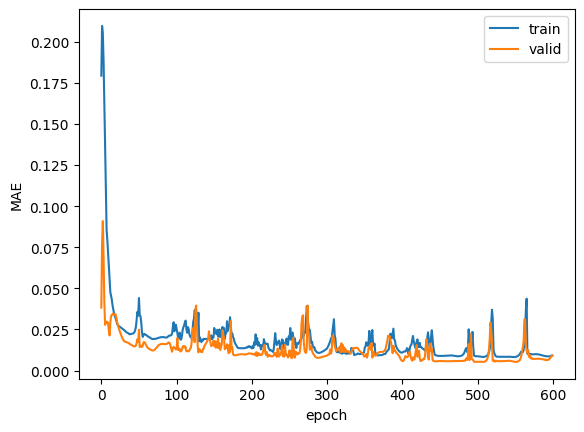

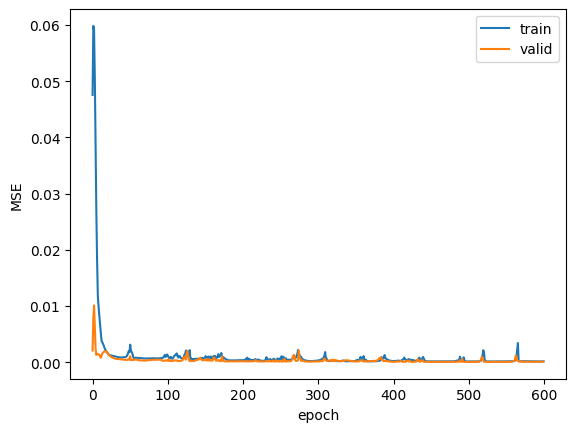

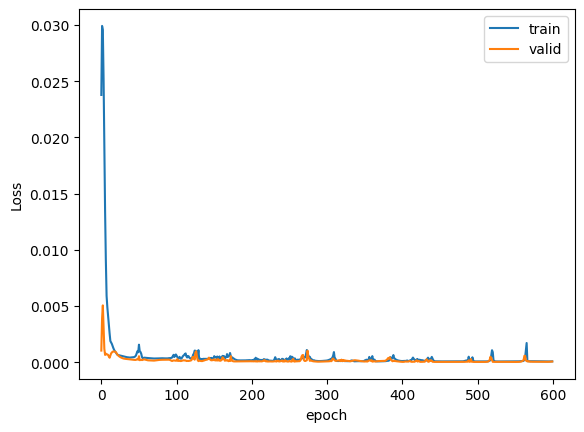

Training time: 334.9064290523529
min MAE in train & valid: 0.008194565773010254 , 0.005258641671389341
min MSE in train & valid: 0.00011957783863181248 , 4.612794873537496e-05
last epoch MAE in train & valid: 0.00916442833840847 , 0.009063960053026676
last epoch MSE in train & valid: 0.00014498115342576057 , 0.00011836212797788903


In [5]:
## Testing: No loop run, train+valid is 85% of all data, ~12.5 min for 600 epochs

keras.backend.clear_session()

XF = X[:,:,0:6]
XT = X[:,:,6:12]
model = ft_model(XF,XT)

start_time = timeit.time()
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=["mse","mae"])
save_weights_at = 'ckpt.weights.h5'
callback = tf.keras.callbacks.ModelCheckpoint(save_weights_at, monitor='val_mse', save_best_only=True, save_weights_only=True)
history = model.fit({"Fund": XF[0:split_valid], "Tech": XT[0:split_valid],}, yy[0:split_valid], 
                    epochs=600, batch_size=64, verbose=0, validation_split=0.15, shuffle=False, callbacks=[callback])
train_time = timeit.time()-start_time

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper right')
plt.show()

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper right')
plt.show()

print('Training time:', train_time)
print('min MAE in train & valid:', min(history.history['mae']), ',', min(history.history['val_mae']))
print('min MSE in train & valid:', min(history.history['mse']), ',', min(history.history['val_mse']))
print('last epoch MAE in train & valid:', min(history.history['mae'][-1:]), ',', min(history.history['val_mae'][-1:]))
print('last epoch MSE in train & valid:', min(history.history['mse'][-1:]), ',', min(history.history['val_mse'][-1:]))

205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step    
Train MAE: 0.018323087842612083
Valid MAE: 0.010113068093388574
Train+Valid MAE: 0.01688581738273542
Train+Valid MAE: 0.01688581738273542


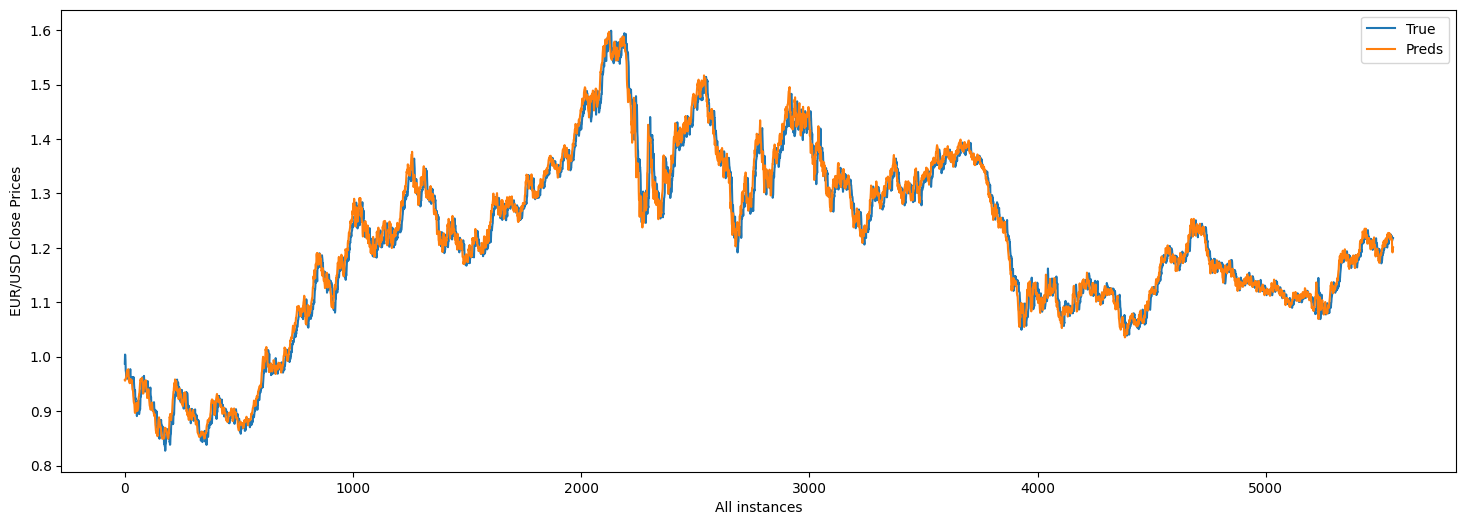

In [6]:
## Values after inverse-transform, results are consistent

model = ft_model(XF,XT)
model.load_weights('ckpt.weights.h5')

# Predictions
yy_pred = model.predict([XF, XT])

# Inverse MinMax then Robust
y_rs_pred = (yy_pred * mmy.data_range_[0]) + mmy.data_min_[0]
#y_rs_pred = (yy_pred)      # if not min max scaled
y_pred = (y_rs_pred * rsy.scale_[0]) + rsy.center_[0]
#y_pred = (y_rs_pred)       # if not robust scaled

pred = y_pred[window_size:split_valid].flatten()
orig = y[window_size:split_valid].flatten()

print('Train MAE:', mean_absolute_error(orig[0:split_train], pred[0:split_train]))
print('Valid MAE:', mean_absolute_error(orig[split_train:split_valid], pred[split_train:split_valid]))
print('Train+Valid MAE:', mean_absolute_error(orig[0:split_valid], pred[0:split_valid]))
print('Train+Valid MAE:', mean_absolute_error(orig[0:split_valid], pred[0:split_valid]))

# Obsered vs Predicted Plot
plt.figure(figsize=(18,6))
plt.plot(orig)         # Valid: [split_train:split_valid]
plt.plot(pred)         # Valid: [split_train:split_valid]
plt.ylabel('EUR/USD Close Prices')
plt.xlabel('All instances')          # Valis/All instances
plt.legend(['True','Preds'], loc='upper right')
plt.show()

In [5]:
## loop run for Dual-input LSTM model (ft_model)

times = []
min_MAE_tr = []
min_MAE_va = []
min_RMSE_tr = []
min_RMSE_va = []
min_LOSS_tr = []
min_LOSS_va = []
MAE_train = []
MAE_valid = []
MAE_trva = []
RMSE_train = []
RMSE_valid = []
RMSE_trva = []

XF = X[:,:,0:6]
XT = X[:,:,6:12]

loop = 0
for loop in range(11):

    keras.backend.clear_session()
    model = ft_model(XF,XT)
    
    start_time = timeit.time()
    model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=["mse","mae"])
    save_weights_at = "model"+str(loop)+".weights.h5"
    callback = tf.keras.callbacks.ModelCheckpoint(save_weights_at, monitor='val_mae', save_best_only=True, save_weights_only=True)
    history = model.fit({"Fund": XF[0:split_valid], "Tech": XT[0:split_valid],}, yy[0:split_valid],
                    epochs=600, batch_size=64, verbose=2, validation_split=0.15, shuffle=False, callbacks=[callback])
    train_time = timeit.time()-start_time
    
    # Predictions
    yy_pred = model.predict([XF, XT])
    
    # Inverse MinMax then Robust
    y_rs_pred = (yy_pred * mmy.data_range_[0]) + mmy.data_min_[0]
    #y_rs_pred = (yy_pred)      # if not min max scaled uncomment and run, comm above
    y_pred = (y_rs_pred * rsy.scale_[0]) + rsy.center_[0]
    #y_pred = (y_rs_pred)       # if not robust scaled uncomment and run, comm above
    
    pred = y_pred[window_size:split_valid].flatten()
    orig = y[window_size:split_valid].flatten()

    # Storing performance metrics 
    times.append(train_time)
    min_MAE_tr.append(min(history.history['mae']))
    min_MAE_va.append(min(history.history['val_mae']))
    min_RMSE_tr.append(math.sqrt(min(history.history['mse'])))
    min_RMSE_va.append(math.sqrt(min(history.history['val_mse'])))
    min_LOSS_tr.append(min(history.history['loss']))
    min_LOSS_va.append(min(history.history['val_loss']))
    MAE_train.append(mean_absolute_error(orig[0:split_train], pred[0:split_train]))
    MAE_valid.append(mean_absolute_error(orig[split_train:split_valid], pred[split_train:split_valid]))
    MAE_trva.append(mean_absolute_error(orig[0:split_valid], pred[0:split_valid]))
    RMSE_train.append(math.sqrt(mean_squared_error(orig[0:split_train], pred[0:split_train])))
    RMSE_valid.append(math.sqrt(mean_squared_error(orig[split_train:split_valid], pred[split_train:split_valid])))
    RMSE_trva.append(math.sqrt(mean_squared_error(orig[0:split_valid], pred[0:split_valid])))

    print(loop)

    loop += 1


results = pd.DataFrame()
results['TIME'] = times
results['min_MAE_tr'] = min_MAE_tr
results['min_MAE_va'] = min_MAE_va
results['min_RMSE_tr'] = min_RMSE_tr
results['min_RMSE_va'] = min_RMSE_va
results['min_LOSS_tr'] = min_LOSS_tr
results['min_LOSS_va'] = min_LOSS_va
results['MAE_train'] = MAE_train
results['MAE_valid'] = MAE_valid
results['MAE_trva'] = MAE_trva
results['RMSE_train'] = RMSE_train
results['RMSE_valid'] = RMSE_valid
results['RMSE_trva'] = RMSE_trva
results.to_csv('results.csv')
results.describe()

Epoch 1/600
70/70 - 25s - loss: 5.1430e-05 - mse: 1.0286e-04 - mae: 0.0075 - val_loss: 1.8185e-05 - val_mse: 3.6370e-05 - val_mae: 0.0047 - 25s/epoch - 350ms/step
Epoch 2/600
70/70 - 1s - loss: 5.1291e-05 - mse: 1.0258e-04 - mae: 0.0075 - val_loss: 1.8123e-05 - val_mse: 3.6245e-05 - val_mae: 0.0046 - 1s/epoch - 20ms/step
Epoch 3/600
70/70 - 1s - loss: 5.1288e-05 - mse: 1.0258e-04 - mae: 0.0075 - val_loss: 1.8114e-05 - val_mse: 3.6228e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 4/600
70/70 - 1s - loss: 5.1286e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8110e-05 - val_mse: 3.6220e-05 - val_mae: 0.0046 - 1s/epoch - 18ms/step
Epoch 5/600
70/70 - 1s - loss: 5.1285e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8108e-05 - val_mse: 3.6215e-05 - val_mae: 0.0046 - 1s/epoch - 18ms/step
Epoch 6/600
70/70 - 1s - loss: 5.1285e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8106e-05 - val_mse: 3.6212e-05 - val_mae: 0.0046 - 1s/epoch - 18ms/step
Epoch 7/600
70/70 - 1s - loss: 5.1284

Epoch 52/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 18ms/step
Epoch 53/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 18ms/step
Epoch 54/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 18ms/step
Epoch 55/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 18ms/step
Epoch 56/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 18ms/step
Epoch 57/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 58/600
70/70 - 1s - loss: 5.

Epoch 103/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 104/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 105/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 106/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 107/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 108/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 109/600
70/70 - 1s - l

Epoch 154/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 18ms/step
Epoch 155/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 156/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 157/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 158/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 159/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 160/600
70/70 - 1s - l

Epoch 205/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 206/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 207/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 208/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 209/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 16ms/step
Epoch 210/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 211/600
70/70 - 1s - l

Epoch 256/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 257/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 258/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 259/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 260/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 261/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 262/600
70/70 - 1s - l

Epoch 307/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 308/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 309/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 310/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 311/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 312/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 313/600
70/70 - 1s - l

Epoch 358/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 359/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 16ms/step
Epoch 360/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 16ms/step
Epoch 361/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 362/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 363/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 364/600
70/70 - 1s - l

Epoch 409/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 410/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 411/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 412/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 16ms/step
Epoch 413/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 16ms/step
Epoch 414/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 415/600
70/70 - 1s - l

Epoch 460/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 461/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 462/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 463/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 464/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 16ms/step
Epoch 465/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 466/600
70/70 - 1s - l

Epoch 511/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 512/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 513/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 514/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 515/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 516/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 517/600
70/70 - 1s - l

Epoch 562/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 563/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 564/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 565/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 566/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 567/600
70/70 - 1s - loss: 5.1284e-05 - mse: 1.0257e-04 - mae: 0.0075 - val_loss: 1.8098e-05 - val_mse: 3.6196e-05 - val_mae: 0.0046 - 1s/epoch - 17ms/step
Epoch 568/600
70/70 - 1s - l

,TIME,min_MAE_tr,min_MAE_va,min_RMSE_tr,min_RMSE_va,min_LOSS_tr,min_LOSS_va,MAE_train,MAE_valid,MAE_trva,RMSE_train,RMSE_valid,RMSE_trva
count,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mean,741.787171,0.007505,0.00464,0.010128,0.006016,0.000051,0.000018,0.399157,0.309801,0.383533,0.436823,0.313305,0.417868
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,741.787171,0.007505,0.00464,0.010128,0.006016,0.000051,0.000018,0.399157,0.309801,0.383533,0.436823,0.313305,0.417868
25%,741.787171,0.007505,0.00464,0.010128,0.006016,0.000051,0.000018,0.399157,0.309801,0.383533,0.436823,0.313305,0.417868
50%,741.787171,0.007505,0.00464,0.010128,0.006016,0.000051,0.000018,0.399157,0.309801,0.383533,0.436823,0.313305,0.417868
75%,741.787171,0.007505,0.00464,0.010128,0.006016,0.000051,0.000018,0.399157,0.309801,0.383533,0.436823,0.313305,0.417868
max,741.787171,0.007505,0.00464,0.010128,0.006016,0.000051,0.000018,0.399157,0.309801,0.383533,0.436823,0.313305,0.417868
